In [1]:
!pip install pandas geopandas plotly pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 21.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving 1.csv to 1.csv
Saving ne_110m_admin_0_countries.cpg to ne_110m_admin_0_countries.cpg
Saving ne_110m_admin_0_countries.dbf to ne_110m_admin_0_countries.dbf
Saving ne_110m_admin_0_countries.prj to ne_110m_admin_0_countries.prj
Saving ne_110m_admin_0_countries.README.html to ne_110m_admin_0_countries.README.html
Saving ne_110m_admin_0_countries.shp to ne_110m_admin_0_countries.shp
Saving ne_110m_admin_0_countries.shx to ne_110m_admin_0_countries.shx
Saving ne_110m_admin_0_countries.VERSION.txt to ne_110m_admin_0_countries.VERSION.txt
Saving tweetid_userid_keyword_topics_sentiments_emotions (5k sample).csv to tweetid_userid_keyword_topics_sentiments_emotions (5k sample).csv
Saving daily-new-confirmed-covid-19-cases-per-million-people.csv to daily-new-confirmed-covid-19-cases-per-million-people.csv


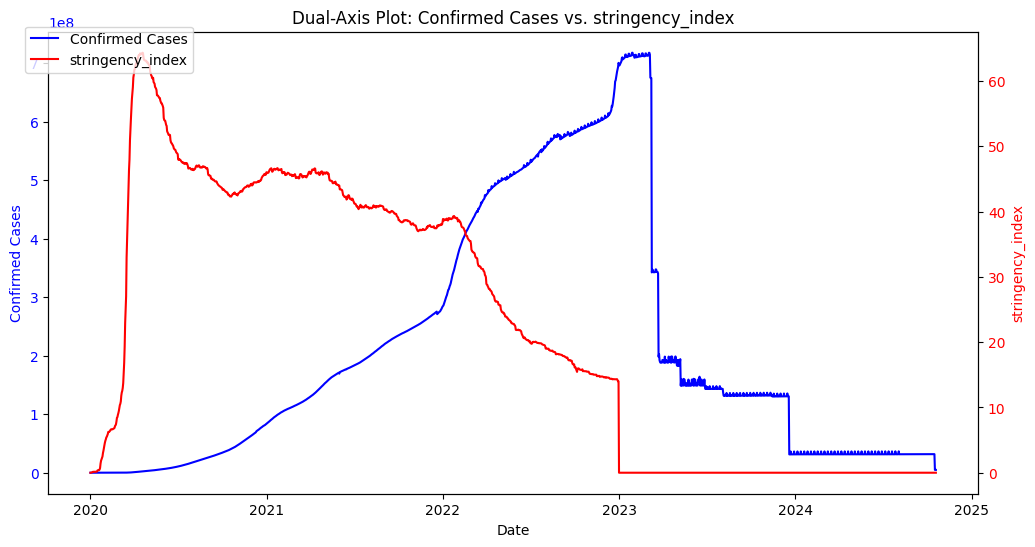

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset from "1.csv" and remove extra spaces in column names
data = pd.read_csv('1.csv', low_memory=False)
data.columns = data.columns.str.strip()

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Convert 'confirmed' and the policy index column to numeric.
# Here, we choose 'stringency_index' as an example policy indicator.
data['confirmed'] = pd.to_numeric(data['confirmed'], errors='coerce').fillna(0)
policy_index = 'stringency_index'
data[policy_index] = pd.to_numeric(data[policy_index], errors='coerce').fillna(0)

# Group data by date.
# For confirmed cases, we take the sum for each date.
# For the policy index, we take the average for each date.
grouped = data.groupby('date').agg({'confirmed': 'sum', policy_index: 'mean'}).reset_index()

# Sort the grouped data by date
grouped = grouped.sort_values('date')

# Create a dual-axis plot using matplotlib.
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot confirmed cases on the left y-axis (blue line)
ax1.plot(grouped['date'], grouped['confirmed'], color='blue', label='Confirmed Cases')
ax1.set_xlabel('Date')
ax1.set_ylabel('Confirmed Cases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot the policy index on the right y-axis (red line)
ax2.plot(grouped['date'], grouped[policy_index], color='red', label=policy_index)
ax2.set_ylabel(policy_index, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legend
plt.title('Dual-Axis Plot: Confirmed Cases vs. ' + policy_index)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [4]:
import pandas as pd
import plotly.express as px

# Load the dataset and clean column names
data = pd.read_csv('1.csv', low_memory=False)
data.columns = data.columns.str.strip()

# Convert 'date' to datetime format and ensure correct data type
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Filter out any incorrect dates (ensure all are after 2019)
data = data[(data['date'] >= '2019-01-01') & (data['date'] <= '2025-01-01')]

# Convert relevant columns to numeric and fill missing values with 0
numeric_cols = ['confirmed', 'deaths', 'recovered', 'tests', 'people_vaccinated', 'people_fully_vaccinated']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)

# Ensure 'administrative_area_level_1' exists
if 'administrative_area_level_1' not in data.columns:
    raise ValueError("Column 'administrative_area_level_1' not found in the dataset.")

# Aggregate confirmed cases, deaths, recoveries, and testing data per day per country
grouped = data.groupby(['date', 'administrative_area_level_1'], as_index=False)[numeric_cols].sum()

# Compute total confirmed cases per country
total_cases = grouped.groupby('administrative_area_level_1')['confirmed'].sum().reset_index()

# Select the top 10 countries with the highest total confirmed cases
top_countries = total_cases.nlargest(10, 'confirmed')['administrative_area_level_1']

# Filter the dataset to include only top countries
filtered_data = grouped[grouped['administrative_area_level_1'].isin(top_countries)]

# Ensure date sorting and correct type
filtered_data = filtered_data.sort_values('date')
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Get min and max dates for the x-axis
min_date = filtered_data['date'].min()
max_date = filtered_data['date'].max()

# Create an interactive line plot with a time slider and range selector
fig = px.line(
    filtered_data,
    x='date',
    y='confirmed',
    color='administrative_area_level_1',
    title='COVID-19 Trends in Top 10 Countries',
    labels={'confirmed': 'Confirmed Cases', 'date': 'Date', 'administrative_area_level_1': 'Country'},
    log_y=True,  # Log scale for better visualization
    hover_data={'confirmed': True, 'date': True}
)

# Update layout to include a range slider and selector with fixed min/max dates
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=7, label="1W", step="day", stepmode="backward"),
                dict(count=30, label="1M", step="day", stepmode="backward"),
                dict(count=180, label="6M", step="day", stepmode="backward"),
                dict(count=365, label="1Y", step="day", stepmode="backward"),
                dict(step="all")  # Show full range
            ])
        ),
        rangeslider=dict(visible=True),  # Enable range slider
        type="date",
        range=[min_date, max_date]  # Manually set x-axis range
    ),
    height=800  # Increase height for better readability
)

# Show the interactive plot
fig.show()

In [5]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load the dataset and clean column names
data = pd.read_csv('1.csv', low_memory=False)
data.columns = data.columns.str.strip()

# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Filter out invalid dates
data = data[(data['date'] >= '2019-01-01') & (data['date'] <= '2025-01-01')]

# Convert relevant columns to numeric
numeric_cols = ['confirmed', 'deaths', 'recovered', 'tests', 'people_vaccinated', 'people_fully_vaccinated']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Ensure 'administrative_area_level_1' exists
if 'administrative_area_level_1' not in data.columns:
    raise ValueError("Column 'administrative_area_level_1' not found in the dataset.")

# Aggregate confirmed cases per day per country
grouped = data.groupby(['date', 'administrative_area_level_1'], as_index=False)[numeric_cols].sum()

# **Apply forward-fill but do NOT fill beyond the last known value**
grouped.sort_values(['administrative_area_level_1', 'date'], inplace=True)
grouped[numeric_cols] = grouped.groupby('administrative_area_level_1')[numeric_cols].ffill()

# **Ensure confirmed cases are monotonically increasing**
grouped['confirmed'] = grouped.groupby('administrative_area_level_1')['confirmed'].cummax()

# Compute total confirmed cases per country
total_cases = grouped.groupby('administrative_area_level_1')['confirmed'].max().reset_index()

# Select the top 10 countries
top_countries = total_cases.nlargest(10, 'confirmed')['administrative_area_level_1']

# Filter data to include only top countries
filtered_data = grouped[grouped['administrative_area_level_1'].isin(top_countries)]

# Ensure sorting
filtered_data = filtered_data.sort_values('date')

# Remove points where there is no data (avoid trailing zeros)
filtered_data = filtered_data[filtered_data['confirmed'] > 0]

# Sample data to reduce scatter points
N = 10
sampled_data = filtered_data.iloc[::N]

# Create interactive plot
fig = px.line(
    filtered_data,
    x='date',
    y='confirmed',
    color='administrative_area_level_1',
    title='COVID-19 Trends in Top 10 Countries',
    labels={'confirmed': 'Confirmed Cases', 'date': 'Date', 'administrative_area_level_1': 'Country'},
    log_y=True,  # Default to log scale
    hover_data={'confirmed': True, 'date': True}
)

# Add scatter points
fig.add_scatter(
    x=sampled_data['date'],
    y=sampled_data['confirmed'],
    mode='markers',
    marker=dict(size=6, opacity=0.7, line=dict(width=0.8, color='black')),
    name="Sampled Daily Cases"
)

# Update layout (fix legend and rangeselector positions)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=[
                dict(count=7, label="1W", step="day", stepmode="backward"),
                dict(count=30, label="1M", step="day", stepmode="backward"),
                dict(count=180, label="6M", step="day", stepmode="backward"),
                dict(count=365, label="1Y", step="day", stepmode="backward"),
                dict(step="all")
            ]
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(
        title="Confirmed Cases",
    ),
    xaxis_title="Date",
    height=800,
    template="plotly_white",
    font=dict(family="Arial, sans-serif", size=14, color="black"),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(
        title="Country",
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.2
    ),
    hovermode="x unified"
)

# **Add interactive buttons to switch between log and linear scale**
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.5,  # Positioning the buttons at the center
            y=1.2,  # Move above the graph
            buttons=[
                dict(
                    label="Log Scale",
                    method="relayout",
                    args=[{"yaxis.type": "log"}]  # Set y-axis to log scale
                ),
                dict(
                    label="Linear Scale",
                    method="relayout",
                    args=[{"yaxis.type": "linear"}]  # Set y-axis to linear scale
                )
            ]
        )
    ]
)

# Show interactive plot
fig.show()